## Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime 
from datetime import timedelta
import plotly.plotly as py
import plotly.tools as tls
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import RNN
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.models import load_model

Morandi = ['#2D241F','#614E52','#7A6747','#A06A50','#ADAEB2','#69647B',
           '#E2CDBC','#A56C41','#B17A7D','#A68782',
          '#903B1C','#92ACD1','#D0C1C6','#D6D6D6','#511F1E']

major_apt = ['ATL','BOS','BWI','CLT','DCA','DEN','DFW','DTW','EWR','FLL','HNL','IAD',
             'IAH','JFK','LAS','LAX','LGA','MCO','MDW','MEM','MIA','MSP','ORD','PHL',
             'PHX','PDX','SAN','SEA','SFO','SLC','TPA','LGB','OAK','SNA']

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import warnings
warnings.simplefilter('ignore')

Using TensorFlow backend.


In [2]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [3]:
def train_lstm(X_train, y_train, params):
    
    # get the hyper-parameters
    n_steps_in = params['n_steps_in']
    n_steps_out = params['n_steps_out']
    loss = params['loss']
    epochs = params['epochs']
    validation_split = params['validation_split']
    batch_size = params['batch_size']
    
    # define the number of features 
    n_features = X_train.shape[2]
    
    # define model
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
    #model.add(Dropout(0.5))
    #model.add(LSTM(100, activation='relu', return_sequences=True))
    #model.add(Dropout(0.5))
    model.add(LSTM(32, activation='relu'))
    #model.add(LSTM(128, activation='relu', return_sequences=True))
    #model.add(LSTM(64, activation='relu', return_sequences=True))
    #model.add(LSTM(32, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss=loss)
    
    # fit model
    lstm = model.fit(X_train, y_train, epochs=epochs, verbose=1, batch_size = batch_size, validation_split=validation_split)
    
    return lstm, model

In [4]:
def train_ende(X_train, y_train, params):
    
    # get the hyper-parameters
    n_steps_in = params['n_steps_in']
    n_steps_out = params['n_steps_out']
    loss = params['loss']
    epochs = params['epochs']
    validation_split = params['validation_split']
    batch_size = params['batch_size']
    
    # define the number of features 
    n_features = X_train.shape[2]
    
    # define model
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(n_steps_in, n_features),return_sequences=True))
    #model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(LSTM(1, activation='relu'))
    model.add(RepeatVector(n_steps_out))
    model.add(LSTM(12, activation='relu', return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=True))
    #model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer='adam', loss='mae')
    
    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    
    # fit model
    ende = model.fit(X_train, y_train, epochs=epochs, verbose=1, batch_size = batch_size, validation_split=validation_split)
       
    return ende, model

In [5]:
def make_prediction(model,X_test,y_test):
    
    # predict on the testing set
    y_pred = model.predict(X_test, verbose=1)
    y_pred_last = [i[-1] for i in y_pred]
    y_test_last = [i[-1] for i in y_test]
    
    return y_pred_last, y_test_last
    #return y_pred_last, y_test

In [6]:
def get_array(dataset, airport = 'BOS'):
    
    base_apr = dataset[dataset['ORIGIN']==airport]
    base_apr.loc[:,'AVG_DEP_DELAY2'] = base_apr['AVG_DEP_DELAY']
    
    # split the training and testing set
    test = base_apr[base_apr['Month'].isin([8,9])]
    train = base_apr[~base_apr['Month'].isin([8,9])]
    
    # drop irrelevant columns
    train.drop(['CRS_DEP_DT','ORIGIN'],axis=1,inplace=True)
    test.drop(['CRS_DEP_DT','ORIGIN'],axis=1,inplace=True)
    
    # change the order of the columns
    train = train[['CRS_DEP_Hr', 'Weekday', 'Month', 'Day', 'DEP_CNT', 'ARR_CNT', 'AVG_DEP_DELAY','AVG_DEP_DELAY2']]
    test = test[['CRS_DEP_Hr', 'Weekday', 'Month', 'Day', 'DEP_CNT', 'ARR_CNT', 'AVG_DEP_DELAY','AVG_DEP_DELAY2']]
    
    # convert DataFrame to vectors
    train_array = train.values
    test_array = test.values
    
    return train_array, test_array

In [7]:
# a for loop to get all airport data into sequence
def get_all_airport(dataset,major_apt,params):
    
    n_steps_in = params['n_steps_in']
    n_steps_out = params['n_steps_out']
    
    for index,name in enumerate(major_apt):
        train_array , test_array = get_array(dataset,name)
        
        #  prepare the training and testing set
        X_train, y_train = split_sequences(train_array,n_steps_in,n_steps_out)
        X_test, y_test = split_sequences(test_array,n_steps_in,n_steps_out)
        
        # concatenate all airports
        if index == 0:
            X_train_all = X_train
            y_train_all = y_train
            X_test_all = X_test
            y_test_all = y_test
        else:
            X_train_all = np.concatenate((X_train_all,X_train),axis=0)
            y_train_all = np.concatenate((y_train_all,y_train),axis=0)
            X_test_all = np.concatenate((X_test_all,X_test),axis=0)
            y_test_all = np.concatenate((y_test_all,y_test),axis=0)   
            
    return X_train_all, y_train_all, X_test_all, y_test_all

In [39]:
datetime_cols = ['CRS_DEP_DT','DEP_DELAY_TD','CRS_ELAPSED_TD','DEP_DT',
                 'CRS_ARR_DT','ARR_DELAY_TD','ARR_DT','ARR_DT_prev']

training_prev = pd.read_csv('training_prev.csv',index_col = 0, parse_dates = datetime_cols)

In [40]:
training_prev.columns

Index(['FL_DATE', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN', 'DEST_AIRPORT_ID', 'DEST', 'DEP_DELAY',
       'ARR_DELAY', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
       'DISTANCE', 'CRS_DEP_DT', 'DEP_DELAY_TD', 'CRS_ELAPSED_TD', 'DEP_DT',
       'Weekday', 'Month', 'Day', 'Week_no', 'CRS_ARR_DT', 'ARR_DELAY_TD',
       'ARR_DT', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'uvIndex', 'visibility', 'winddir16Point', 'winddirDegree',
       'windspeedKmph', 'weatherDesc_new', 'Wide', 'Year', 'DEST_prev',
       'ARR_DT_prev', 'Turnaround_time', 'CRS_ARR_DT_prev', 'DISTANCE_prev',
       'DEP_DELAY_prev', 'DEP_DELAY_CAT', 'DEP_DELAY_BI', 'AVG_DELAY6',
       'EST_TRN', 'ARP_DELAY', 'DEP_CNT', 'ARR_CNT', 'OD', 'Last2', 'Last8',
       'OD_DELAY6', 'AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'G4', 'HA', 'MQ', 'NK',
       'OH', 'OO', 'UA',

In [41]:
training_prev.shape

(3342691, 85)

## Preprocessing

### Prepare the dataset for the LSTM model

In [42]:
Maj_ORI = training_prev[training_prev['ORIGIN'].isin(major_apt)]
CRS_DEP_DT = Maj_ORI['CRS_DEP_DT']
Maj_ORI = pd.DataFrame(Maj_ORI.groupby(['ORIGIN',
                                        CRS_DEP_DT.dt.date,
                                        CRS_DEP_DT.dt.hour]).agg({'DEP_DELAY':['count','mean']}))

In [43]:
Maj_ORI.index.names = ['ORIGIN','CRS_DEP_DT','CRS_DEP_Hr']
Maj_ORI = Maj_ORI.reset_index()
Maj_ORI.columns = Maj_ORI.columns.droplevel()
Maj_ORI.columns = ['ORIGIN','CRS_DEP_DT','CRS_DEP_Hr','DEP_CNT','AVG_DEP_DELAY']

In [44]:
Maj_DEST = training_prev[training_prev['DEST'].isin(major_apt)]
CRS_ARR_DT = Maj_DEST['CRS_ARR_DT']
Maj_DEST = pd.DataFrame(Maj_DEST.groupby(['DEST',
                                          CRS_ARR_DT.dt.date,
                                          CRS_ARR_DT.dt.hour]).size())

In [45]:
Maj_DEST.index.names = ['DEST','CRS_ARR_DT','CRS_ARR_Hr']
Maj_DEST = Maj_DEST.reset_index()
Maj_DEST.columns = ['DEST','CRS_ARR_DT','CRS_ARR_Hr','ARR_CNT']

In [46]:
from itertools import product
base = pd.date_range('2018-01-01', periods=6384, freq='1H')
base = list(product(base,major_apt))
base_df = pd.DataFrame(base,columns=['CRS_DEP_DT','ORIGIN'])
base_df['CRS_DEP_Hr'] = base_df['CRS_DEP_DT'].dt.hour
base_df['Weekday'] = base_df['CRS_DEP_DT'].dt.weekday
base_df['Month'] = base_df['CRS_DEP_DT'].dt.month
base_df['Day'] = base_df['CRS_DEP_DT'].dt.day
base_df['CRS_DEP_DT'] = base_df['CRS_DEP_DT'].dt.date

In [47]:
base_df.tail()

,CRS_DEP_DT,ORIGIN,CRS_DEP_Hr,Weekday,Month,Day
217051,2018-09-23,SLC,23,6,9,23
217052,2018-09-23,TPA,23,6,9,23
217053,2018-09-23,LGB,23,6,9,23
217054,2018-09-23,OAK,23,6,9,23
217055,2018-09-23,SNA,23,6,9,23


In [48]:
base_df.shape

(217056, 6)

### Merge Maj_ORI with base_df

In [49]:
base_df = pd.merge(base_df,Maj_ORI,
                   left_on=['ORIGIN','CRS_DEP_DT','CRS_DEP_Hr'],
                   right_on=['ORIGIN','CRS_DEP_DT','CRS_DEP_Hr'],
                   how='left')

In [50]:
base_df.shape

(217056, 8)

In [51]:
base_df = base_df.fillna(0)

In [52]:
base_df.head()

,CRS_DEP_DT,ORIGIN,CRS_DEP_Hr,Weekday,Month,Day,DEP_CNT,AVG_DEP_DELAY
0,2018-01-01,ATL,0,0,1,1,0.0,0.0
1,2018-01-01,BOS,0,0,1,1,0.0,0.0
2,2018-01-01,BWI,0,0,1,1,0.0,0.0
3,2018-01-01,CLT,0,0,1,1,0.0,0.0
4,2018-01-01,DCA,0,0,1,1,0.0,0.0


### Merge Maj_DEST with base_df

In [53]:
base_df = pd.merge(base_df,Maj_DEST,
                   left_on=['ORIGIN','CRS_DEP_DT','CRS_DEP_Hr'],
                   right_on=['DEST','CRS_ARR_DT','CRS_ARR_Hr'],
                   how='left')

In [54]:
base_df.shape

(217056, 12)

In [55]:
base_df = base_df.fillna(0)
base_df.drop(['DEST','CRS_ARR_DT','CRS_ARR_Hr'],axis=1,inplace=True)

In [56]:
base_df.head()

,CRS_DEP_DT,ORIGIN,CRS_DEP_Hr,Weekday,Month,Day,DEP_CNT,AVG_DEP_DELAY,ARR_CNT
0,2018-01-01,ATL,0,0,1,1,0.0,0.0,0.0
1,2018-01-01,BOS,0,0,1,1,0.0,0.0,0.0
2,2018-01-01,BWI,0,0,1,1,0.0,0.0,0.0
3,2018-01-01,CLT,0,0,1,1,0.0,0.0,0.0
4,2018-01-01,DCA,0,0,1,1,0.0,0.0,0.0


### Merge with weather data

In [57]:
all_weather = pd.read_csv('all_weather_data.csv')

In [58]:
all_weather['Datetime'] = pd.to_datetime(all_weather['Datetime']).dt.date

In [59]:
all_weather.columns

Index(['Unnamed: 0', 'Airport_name', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM',
       'pressure', 'tempC', 'uvIndex', 'visibility', 'winddir16Point',
       'winddirDegree', 'windspeedKmph', 'weatherDesc_new', 'Datetime',
       'Hour'],
      dtype='object')

In [90]:
all_weather = all_weather[['Airport_name','DewPointC', 'cloudcover', 'humidity', 'precipMM',
                           'pressure', 'tempC', 'uvIndex', 'visibility', 'windspeedKmph','Datetime','Hour']]

In [91]:
base_wea = pd.merge(base_df,all_weather,
                    left_on=['ORIGIN','CRS_DEP_DT','CRS_DEP_Hr'],
                    right_on=['Airport_name','Datetime','Hour'],
                    how='left') 

In [92]:
base_wea.drop(['Airport_name','Datetime','Hour'],axis=1,inplace=True)

In [93]:
base_wea.shape

(217056, 18)

### Set average delay to 0 for those hours with only 1 or 2 flights

In [94]:
base_wea['AVG_DEP_DELAY'][base_wea['DEP_CNT'] <= 2] = 0

## LSTM

In [59]:
base_wea.to_csv('base_wea.csv')

In [8]:
base_wea = pd.read_csv('base_wea.csv',index_col = 0)

In [318]:
lstm_params = {'n_steps_in':12,
               'n_steps_out':3,
               'loss':'mae',
               'epochs':10,
               'batch_size':256,
               'validation_split':0.1}

In [316]:
X_train_all, y_train_all, X_test_all, y_test_all = get_all_airport(dataset=base_wea,major_apt=major_apt,params=lstm_params)

In [321]:
lstm, model = train_lstm(X_train_all, y_train_all, params=lstm_params)

Train on 155295 samples, validate on 17255 samples
Epoch 1/10
155295/155295 [==============================] - 33s 212us/step - loss: 5.0065 - val_loss: 4.2020
Epoch 2/10
155295/155295 [==============================] - 25s 160us/step - loss: 4.2931 - val_loss: 4.0974
Epoch 3/10
155295/155295 [==============================] - 25s 160us/step - loss: 4.1467 - val_loss: 3.9978
Epoch 4/10
155295/155295 [==============================] - 25s 160us/step - loss: 4.0854 - val_loss: 4.0420
Epoch 5/10
155295/155295 [==============================] - 25s 159us/step - loss: 4.0410 - val_loss: 3.9336
Epoch 6/10
155295/155295 [==============================] - 25s 160us/step - loss: 4.0519 - val_loss: 3.9934
Epoch 7/10
155295/155295 [==============================] - 25s 159us/step - loss: 4.0213 - val_loss: 3.9598
Epoch 8/10
155295/155295 [==============================] - 25s 159us/step - loss: 3.9750 - val_loss: 3.9487
Epoch 9/10
155295/155295 [==============================] - 25s 160us/step - 

In [186]:
# save the keras model
model.save('./keras_model/new#6.h5')

In [309]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 12, 100)           43200     
_________________________________________________________________
lstm_50 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total params: 60,257
Trainable params: 60,257
Non-trainable params: 0
_________________________________________________________________


In [322]:
y_pred_last, y_test_last = make_prediction(model, X_test_all, y_test_all)

43622/43622 [==============================] - 8s 181us/step


In [323]:
y_pred_train_last, y_train_last = make_prediction(model, X_train_all, y_train_all)

172550/172550 [==============================] - 20s 115us/step


In [324]:
# move the prediction forward for two steps since there is a lag between y_test and y_pred
y_pred_new = y_pred_last[2:]
y_pred_new.append(0)
y_pred_new.append(0)

In [326]:
from sklearn.metrics import mean_absolute_error
print('Actual MAE: ' + str(mean_absolute_error(y_test_last,y_pred_last)) +
      '; Adjusted MAE: ' + str(mean_absolute_error(y_test_last,y_pred_new)))

Actual MAE: 6.921171647972491; Adjusted MAE: 6.046222024501584


In [204]:
from sklearn.metrics import r2_score
print('Actual R2: ' + str(r2_score(y_test_last,y_pred_last)) + 
      '; Adjusted R2: ' + str(r2_score(y_test_last,y_pred_new)))

Actual R2: 0.4462292994154974; Adjusted R2: 0.5564337823313146


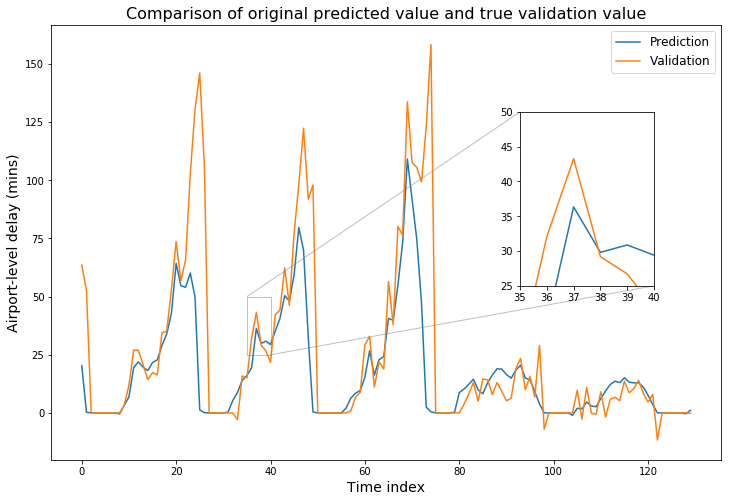

In [328]:
fig, ax = plt.subplots(figsize=[12, 8])
#plt.plot(y_pred_new[1000:1100],label='Adjusted Prediction')
ax.plot(y_pred_new[1530:1660],label='Prediction')
ax.plot(y_test_last[1530:1660],label='Validation')
plt.legend(fontsize = 'large')
plt.title('Comparison of original predicted value and true validation value',size=16)
plt.ylabel('Airport-level delay (mins)',size=14)
plt.xlabel('Time index',size=14)

axins = ax.inset_axes([0.7, 0.4, 0.2, 0.4])
#a = plt.axes([.65, .6, .2, .2], facecolor='white')
axins.plot(y_pred_new[1530:1660])
axins.plot(y_test_last[1530:1660])
x1, x2, y1, y2 = 35, 40, 25, 50
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks(np.arange(35,41))
#axins.set_xticklabels('')
#axins.set_yticklabels('')

ax.indicate_inset_zoom(axins)
plt.savefig("./images/lstm_1.png", dpi=500)
#plt.tight_layout()
plt.show()

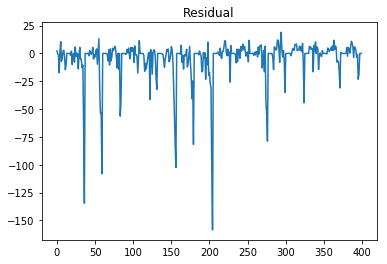

In [207]:
residual = np.array(y_pred_new) - np.array(y_test_last)
#plt.figure(figsize=(20,12))
plt.plot(residual[1400:1800],label='residual')
plt.title('Residual')
plt.show()

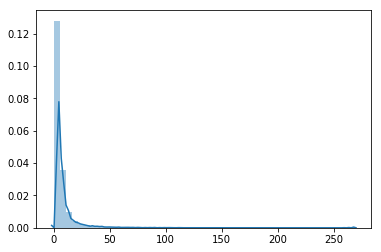

In [208]:
maes = abs(np.array(y_pred_new) - np.array(y_test_last))
ax = sns.distplot(maes)

In [209]:
print(str(round(sum(maes < 10)/len(maes)*100)) + '% of times the error is less than 10 minutes')

86.0% of times the error is less than 10 minutes


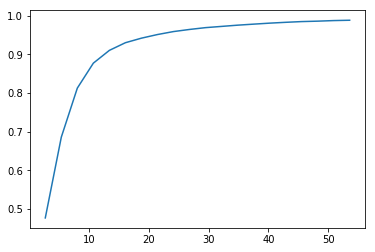

In [211]:
num_bins = 100
counts, bin_edges = np.histogram (maes, bins=num_bins, normed=True)
cdf = np.cumsum (counts)
#plt.figure(figsize=(20,12))
plt.plot (bin_edges[1:21], (cdf/cdf[-1])[:20])
#plt.xticks(np.arange(0,105,5))
plt.show()

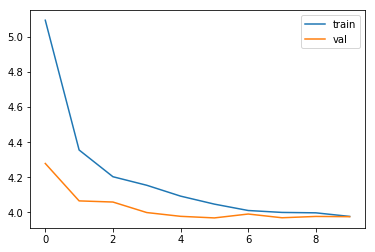

In [79]:
plt.plot(lstm.history['loss'])
plt.plot(lstm.history['val_loss'])
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Predicting on the testing set

In [28]:
lstm_test = pd.read_csv('./test/lstm_testing.csv',index_col=0)

In [80]:
lstm_test.head()

,CRS_DEP_DT,ORIGIN,CRS_DEP_Hr,Weekday,Month,Day,DEP_CNT,AVG_DEP_DELAY,ARR_CNT,DewPointC,cloudcover,precipMM,visibility
0,2018-09-24,ATL,0,0,9,24,0.0,0.0,0.0,17,17,0.0,10
1,2018-09-24,BOS,0,0,9,24,0.0,0.0,0.0,9,6,0.0,10
2,2018-09-24,BWI,0,0,9,24,0.0,0.0,0.0,15,100,0.0,10
3,2018-09-24,CLT,0,0,9,24,0.0,0.0,0.0,17,39,0.0,10
4,2018-09-24,DCA,0,0,9,24,0.0,0.0,0.0,16,100,0.0,10


In [30]:
def get_test_array(dataset, airport = 'BOS'):
    
    base_apr = dataset[dataset['ORIGIN']==airport]
    base_apr.loc[:,'AVG_DEP_DELAY2'] = base_apr['AVG_DEP_DELAY']
    
    # drop irrelevant columns
    base_apr.drop(['CRS_DEP_DT','ORIGIN'],axis=1,inplace=True)
    
    # change the order of the columns
    base_apr = base_apr[['CRS_DEP_Hr', 'Weekday', 'Month', 'Day', 'DEP_CNT', 'ARR_CNT', 'AVG_DEP_DELAY','AVG_DEP_DELAY2']]
    
    # convert DataFrame to vectors
    base_apr_array = base_apr.values
    
    return base_apr_array

In [31]:
# a for loop to get all airport data into sequence
def get_all_test(dataset,major_apt,params):
    
    n_steps_in = params['n_steps_in']
    n_steps_out = params['n_steps_out']
    
    for index,name in enumerate(major_apt):
        test_array = get_test_array(dataset,name)
        
        #  prepare the training and testing set
        X_test, y_test = split_sequences(test_array,n_steps_in,n_steps_out)
        
        # concatenate all airports
        if index == 0:
            X_test_all = X_test
            y_test_all = y_test
        else:
            X_test_all = np.concatenate((X_test_all,X_test),axis=0)
            y_test_all = np.concatenate((y_test_all,y_test),axis=0)   
            
    return X_test_all, y_test_all

In [81]:
X_test_all, y_test_all = get_all_test(dataset=lstm_test, major_apt=major_apt, params=lstm_params)

In [82]:
y_pred_last, y_test_last = make_prediction(model, X_test_all, y_test_all)

80342/80342 [==============================] - 14s 174us/step


In [83]:
# move the prediction forward for two steps since there is a lag between y_test and y_pred
y_pred_new = y_pred_last[2:]
y_pred_new.append(0)
y_pred_new.append(0)

In [84]:
print('Actual MAE: ' + str(mean_absolute_error(y_test_last,y_pred_last)) +
      '; Adjusted MAE: ' + str(mean_absolute_error(y_test_last,y_pred_new)))

Actual MAE: 6.455718875024042; Adjusted MAE: 5.5122272715513665


In [85]:
print('Actual R2: ' + str(r2_score(y_test_last,y_pred_last)) + 
      '; Adjusted MAE: ' + str(r2_score(y_test_last,y_pred_new)))

Actual R2: 0.32675839396494266; Adjusted MAE: 0.5252392634692222


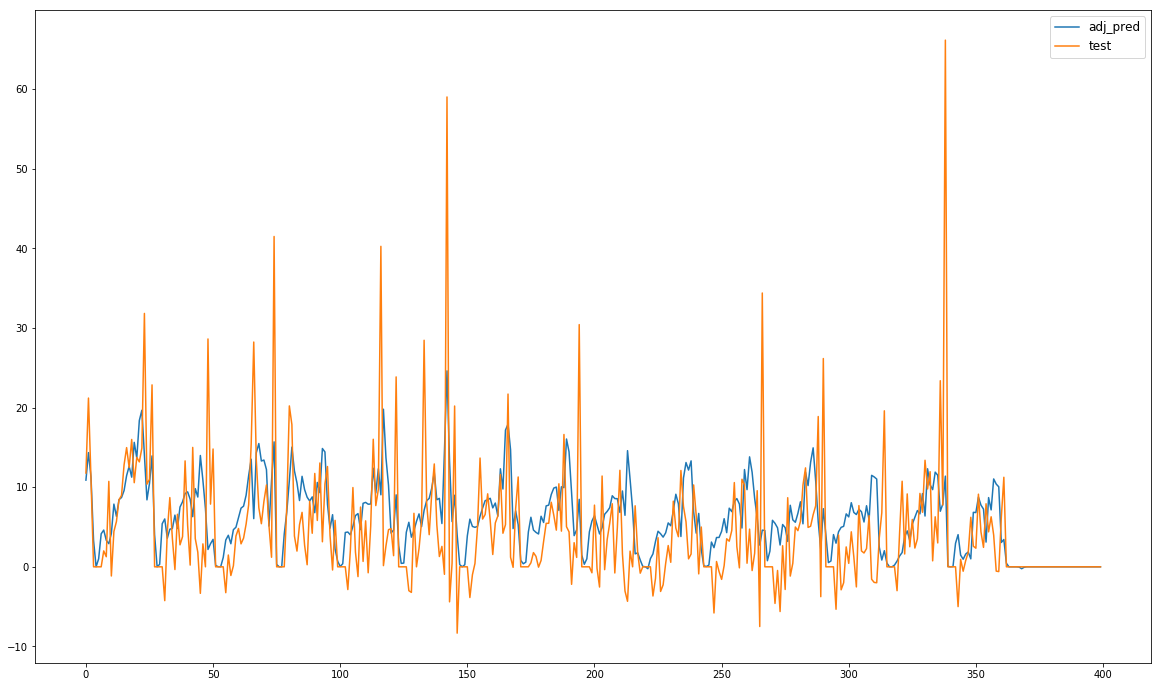

In [88]:
plt.figure(figsize=(20,12))
#plt.plot(y_pred_last[800:900],label='pred')
plt.plot(y_pred_new[12400:12800],label='adj_pred')
plt.plot(y_test_last[12400:12800],label='test')
plt.legend(fontsize = 'large')
plt.show()

## Encoder-decoder model

In [9]:
ende_params = {'n_steps_in':12,
               'n_steps_out':3,
               'loss':'mae',
               'epochs':5,
               'batch_size':256,
               'validation_split':0.1}

In [10]:
X_train_all, y_train_all, X_test_all, y_test_all = get_all_airport(dataset=base_wea,major_apt=major_apt,params=ende_params)

In [11]:
ende,model = train_ende(X_train_all, y_train_all, params=ende_params)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 155295 samples, validate on 17255 samples
Epoch 1/5
155295/155295 [==============================] - 46s 295us/step - loss: 7.9497 - val_loss: 6.0859
Epoch 2/5
155295/155295 [==============================] - 43s 277us/step - loss: 6.2169 - val_loss: 5.4406
Epoch 3/5
155295/155295 [==============================] - 43s 277us/step - loss: 5.6538 - val_loss: 5.2893
Epoch 4/5
155295/155295 [==============================] - 42s 272us/step - loss: 5.4576 - val_loss: 5.1855
Epoch 5/5
155295/155295 [==============================] - 42s 273us/step - loss: 5.2729 - val_loss: 5.0595


In [667]:
# save the keras model
model.save('./keras_model/#13.h5')

In [85]:
# load the model
model = load_model('./keras_model/#11.h5')

In [12]:
y_pred_last, y_test_last = make_prediction(model, X_test_all, y_test_all)

43622/43622 [==============================] - 10s 227us/step


In [371]:
y_pred_train_last, y_train_last = make_prediction(model, X_train_all, y_train_all)

172550/172550 [==============================] - 51s 293us/step


In [14]:
# move the prediction forward for two steps since there is a lag between y_test and y_pred
y_pred_new = y_pred_last[2:]
y_pred_new.append(0)
y_pred_new.append(0)

In [15]:
from sklearn.metrics import mean_absolute_error
print('Actual MAE: ' + str(mean_absolute_error(y_test_last,y_pred_last)) +
      '; Adjusted MAE: ' + str(mean_absolute_error(y_test_last,y_pred_new)))

Actual MAE: 7.706950773835679; Adjusted MAE: 4.319985854967347


In [16]:
from sklearn.metrics import r2_score
print('Actual R2: ' + str(r2_score(y_test_last,y_pred_last)) + 
      '; Adjusted R2: ' + str(r2_score(y_test_last,y_pred_new)))

Actual R2: 0.3590900805130499; Adjusted R2: 0.747904640411927


In [17]:
#maes = abs(np.array(y_pred_new[:-2]) - np.array(y_test_last[:-2]))
maes = abs(np.concatenate(y_pred_new[:-2]).ravel() - y_test_last[:-2])
print(str(round(sum(maes < 10)/len(maes)*100)) + '% of times the error is less than 10 minutes')

90.0% of times the error is less than 10 minutes


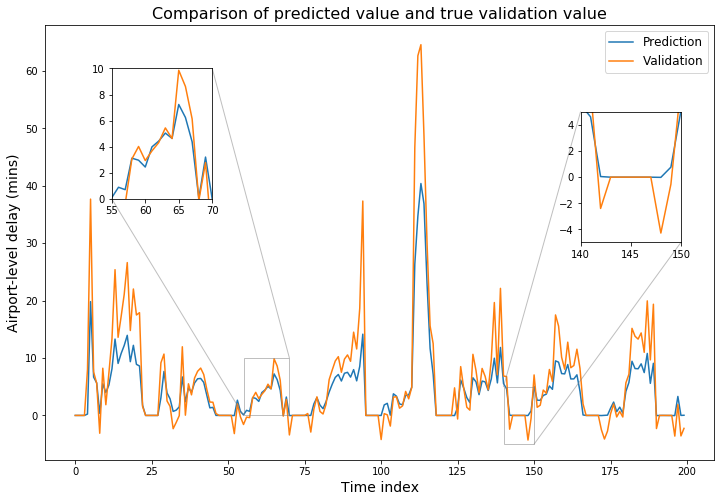

In [55]:
fig, ax = plt.subplots(figsize=[12, 8])
#plt.plot(y_pred_last[400:800],label='pred')
ax.plot(y_pred_new[300:500],label='Prediction')
ax.plot(y_test_last[300:500],label='Validation')
plt.legend(fontsize = 'large')
plt.title('Comparison of predicted value and true validation value',size=16)
plt.ylabel('Airport-level delay (mins)',size=14)
plt.xlabel('Time index',size=14)

axins = ax.inset_axes([0.1, 0.6, 0.15, 0.3])
axins.plot(y_pred_new[300:500])
axins.plot(y_test_last[300:500])
x1, x2, y1, y2 = 55, 70, 0, 10
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

ax.indicate_inset_zoom(axins)

axins2 = ax.inset_axes([0.8, 0.5, 0.15, 0.3])
axins2.plot(y_pred_new[300:500])
axins2.plot(y_test_last[300:500])
x1, x2, y1, y2 = 140, 150, -5, 5
axins2.set_xlim(x1, x2)
axins2.set_ylim(y1, y2)

ax.indicate_inset_zoom(axins2)
plt.savefig("./images/ende_1.png", dpi=500)

plt.show()

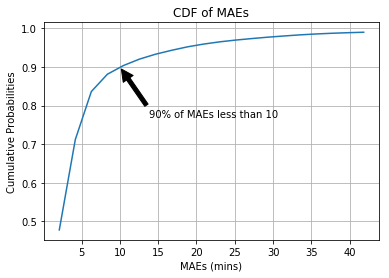

In [42]:
num_bins = 100
counts, bin_edges = np.histogram(maes, bins=num_bins, normed=True)
cdf = np.cumsum(counts)
fig, ax = plt.subplots()
plt.plot(bin_edges[1:21], (cdf/cdf[-1])[:20])
plt.ylabel('Cumulative Probabilities')
plt.xlabel('MAEs (mins)')
plt.title('CDF of MAEs')
plt.grid()
ax.annotate('90% of MAEs less than 10',
            xy=(10, 0.9), xycoords='data',
            xytext=(0.7, 0.6), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')
plt.savefig("./images/ende_2.png", dpi=300)
plt.show()

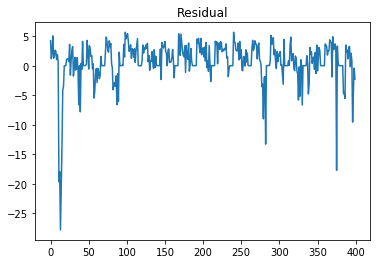

In [19]:
residual = np.array(y_pred_new) - np.array(y_test_last)
#plt.figure(figsize=(20,12))
plt.plot(residual[400:800],label='residual')
plt.title('Residual')
plt.show()

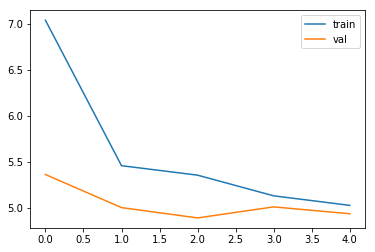

In [43]:
plt.plot(ende.history['loss'])
plt.plot(ende.history['val_loss'])
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Predicting on the testing set

In [18]:
lstm_test = pd.read_csv('./test/lstm_testing.csv',index_col=0)

In [20]:
def get_test_array(dataset, airport = 'BOS'):
    
    base_apr = dataset[dataset['ORIGIN']==airport]
    base_apr.loc[:,'AVG_DEP_DELAY2'] = base_apr['AVG_DEP_DELAY']
    
    # drop irrelevant columns
    base_apr.drop(['CRS_DEP_DT','ORIGIN'],axis=1,inplace=True)
    
    # change the order of the columns
    base_apr = base_apr[['CRS_DEP_Hr', 'Weekday', 'Month', 'Day', 'DEP_CNT', 'ARR_CNT', 'AVG_DEP_DELAY','AVG_DEP_DELAY2']]
    
    # convert DataFrame to vectors
    base_apr_array = base_apr.values
    
    return base_apr_array

In [21]:
# a for loop to get all airport data into sequence
def get_all_test(dataset,major_apt,params):
    
    n_steps_in = params['n_steps_in']
    n_steps_out = params['n_steps_out']
    
    for index,name in enumerate(major_apt):
        test_array = get_test_array(dataset,name)
        
        #  prepare the training and testing set
        X_test, y_test = split_sequences(test_array,n_steps_in,n_steps_out)
        
        # concatenate all airports
        if index == 0:
            X_test_all = X_test
            y_test_all = y_test
        else:
            X_test_all = np.concatenate((X_test_all,X_test),axis=0)
            y_test_all = np.concatenate((y_test_all,y_test),axis=0)   
            
    return X_test_all, y_test_all

In [22]:
X_test_all, y_test_all = get_all_test(dataset=lstm_test, major_apt=major_apt, params=ende_params)

In [23]:
y_pred_last, y_test_last = make_prediction(model, X_test_all, y_test_all)

80342/80342 [==============================] - 17s 217us/step


In [24]:
y_pred_new = y_pred_last[2:]
y_pred_new.append(0)
y_pred_new.append(0)

In [25]:
print('Actual MAE: ' + str(mean_absolute_error(y_test_last,y_pred_last)) +
      '; Adjusted MAE: ' + str(mean_absolute_error(y_test_last,y_pred_new)))

Actual MAE: 5.751541474129935; Adjusted MAE: 3.427613770879944


In [26]:
print('Actual R2: ' + str(r2_score(y_test_last,y_pred_last)) + 
      '; Adjusted MAE: ' + str(r2_score(y_test_last,y_pred_new)))

Actual R2: 0.3346234389395675; Adjusted MAE: 0.6788157462408917


In [45]:
match = lstm_test.iloc[442:].sort_values(by=['ORIGIN','Month','Day','CRS_DEP_Hr'])

In [48]:
print(match.shape,len(y_pred_new))

(80342, 13) 80342


In [49]:
match['Prediction'] = [float(i) for i in y_pred_new]

In [51]:
match.to_csv('./test/lstm_test_pred.csv')

## Predict on the training set

In [114]:
y_pred_train_new = y_pred_train_last[2:]
y_pred_train_new.append(0)
y_pred_train_new.append(0)
print('Actual MAE: ' + str(mean_absolute_error(y_train_last,y_pred_train_last)) +
      '; Adjusted MAE: ' + str(mean_absolute_error(y_train_last,y_pred_train_new)))

Actual MAE: 7.2921104473539975; Adjusted MAE: 3.747374051827091


## Find the corresponding ORIGIN, Month and Day for the prediction

In [132]:
# find the corresponding ORIGIN, Month and Day for the training prediction 
train_match = base_wea[(base_wea['Month'] <= 7)][~((base_wea['Month']==1)&
                                                   (base_wea['Day']==1)&
                                                   (base_wea['CRS_DEP_Hr'] <= 12))].sort_values(by=['ORIGIN','Month','Day'])
print(train_match.shape,len(y_pred_train_new))

(172550, 13) 172550


In [134]:
# find the corresponding ORIGIN, Month and Day for the testing prediction 
test_match = base_wea[(base_wea['Month'] >= 8)][~((base_wea['Month']==8)&
                                                  (base_wea['Day']==1)&
                                                  (base_wea['CRS_DEP_Hr'] <= 12))].sort_values(by=['ORIGIN','Month','Day'])
print(test_match.shape,len(y_pred_new))

(43622, 13) 43622


In [154]:
train_match['Prediction'] = [float(i) for i in y_pred_train_new]
test_match['Prediction'] = [float(i) for i in y_pred_new]

In [157]:
base_ready = pd.concat([train_match,test_match])

In [158]:
base_ready.shape

(216172, 14)

In [159]:
base_ready.to_csv('base_ready.csv')